
===== Chat Data Summary =====
Total conversations: 847
Average messages per conversation: 5.72
Average words per conversation: 60.17
Max messages in a conversation: 7
Max words in a conversation: 136

Successfully loaded data from gulf_chats_merged_all.json
Saved figure to chat_analysis_results/message_count_dist_4-7.png
Saved figure to chat_analysis_results/word_count_dist_bin20_max100.png


/Users/mahmoud/.pyenv/versions/3.12.5/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Saved figure to chat_analysis_results/avg_message_length_dist.png
Saved figure to chat_analysis_results/word_frequency_top15_min4.png
Generating summary report...


/Users/mahmoud/.pyenv/versions/3.12.5/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Saved summary report to chat_analysis_results/summary_report_20250507_192403.png
Analysis completed successfully!


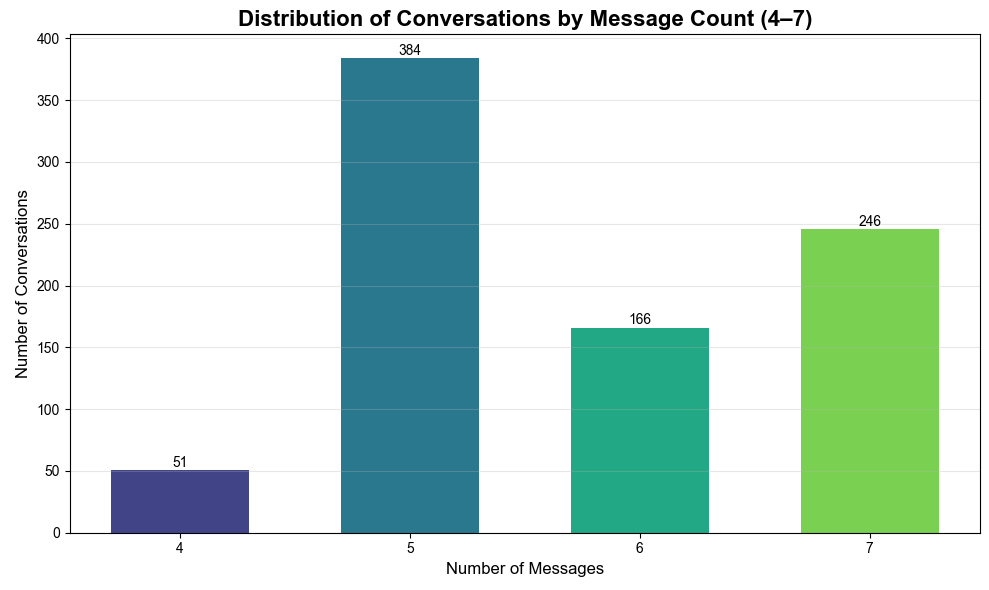

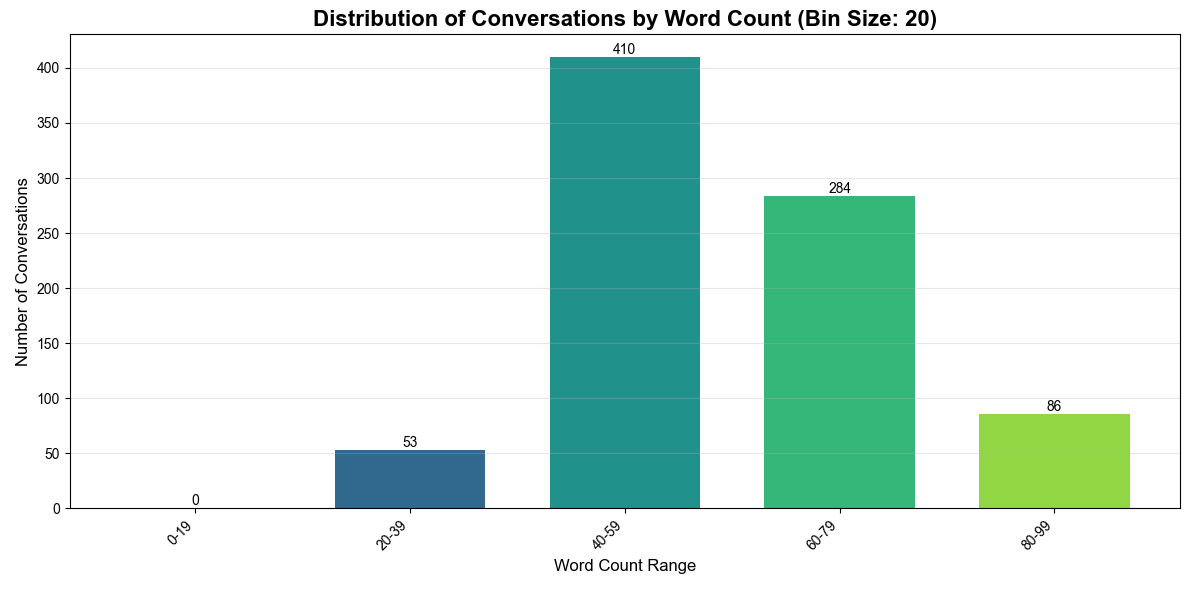

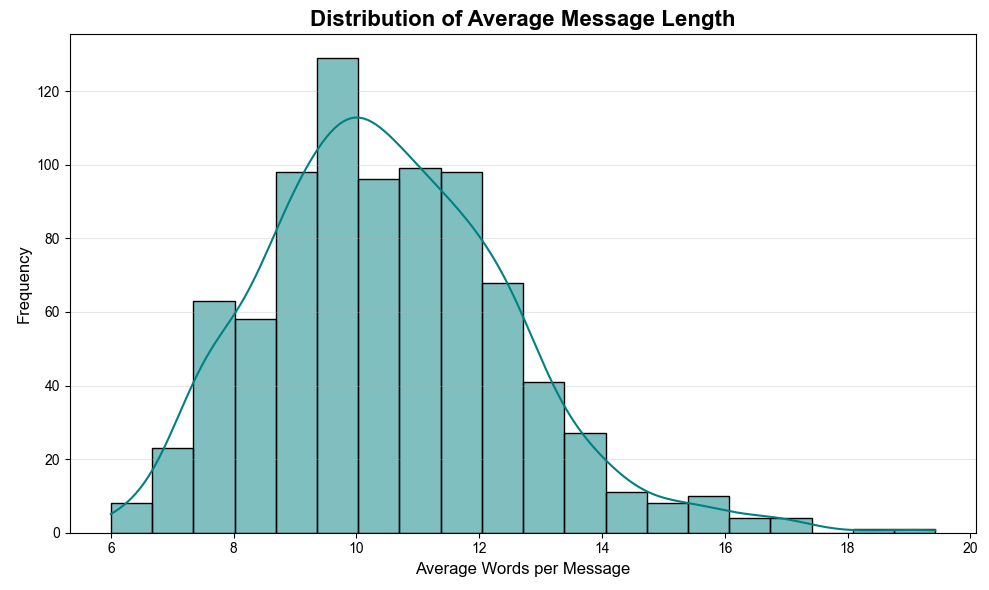

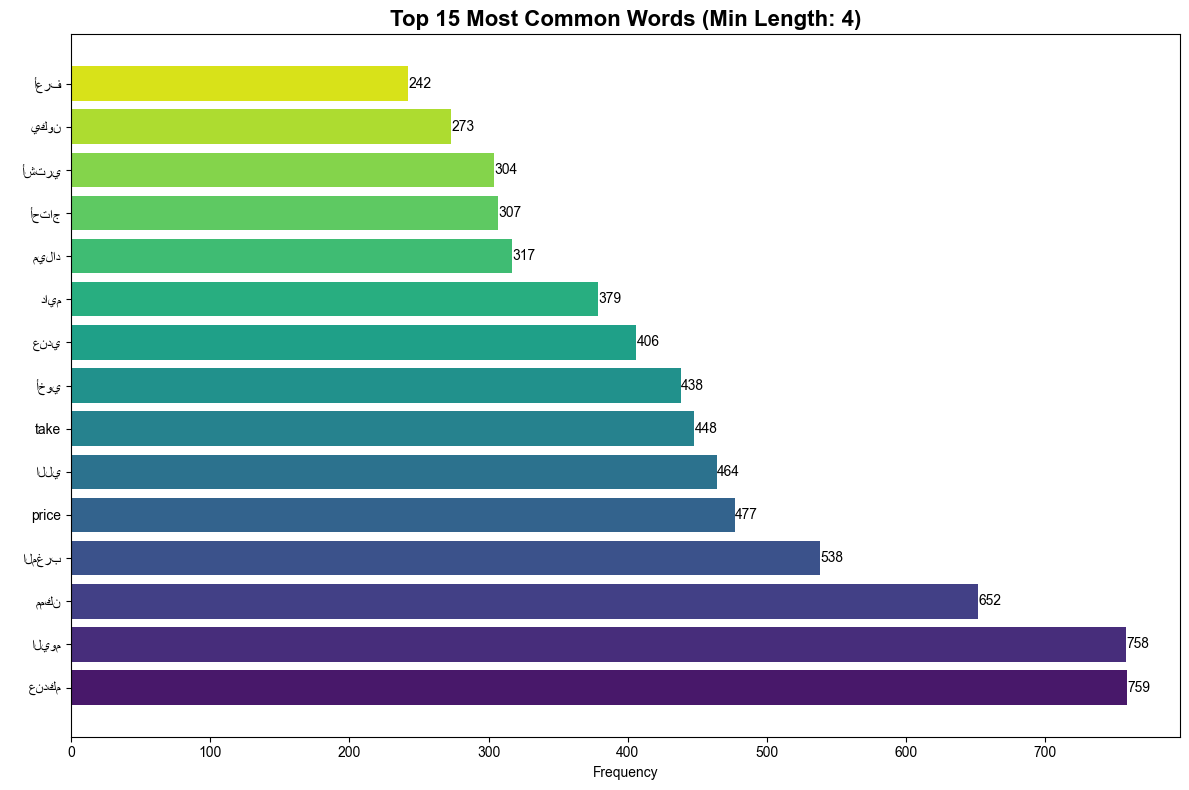

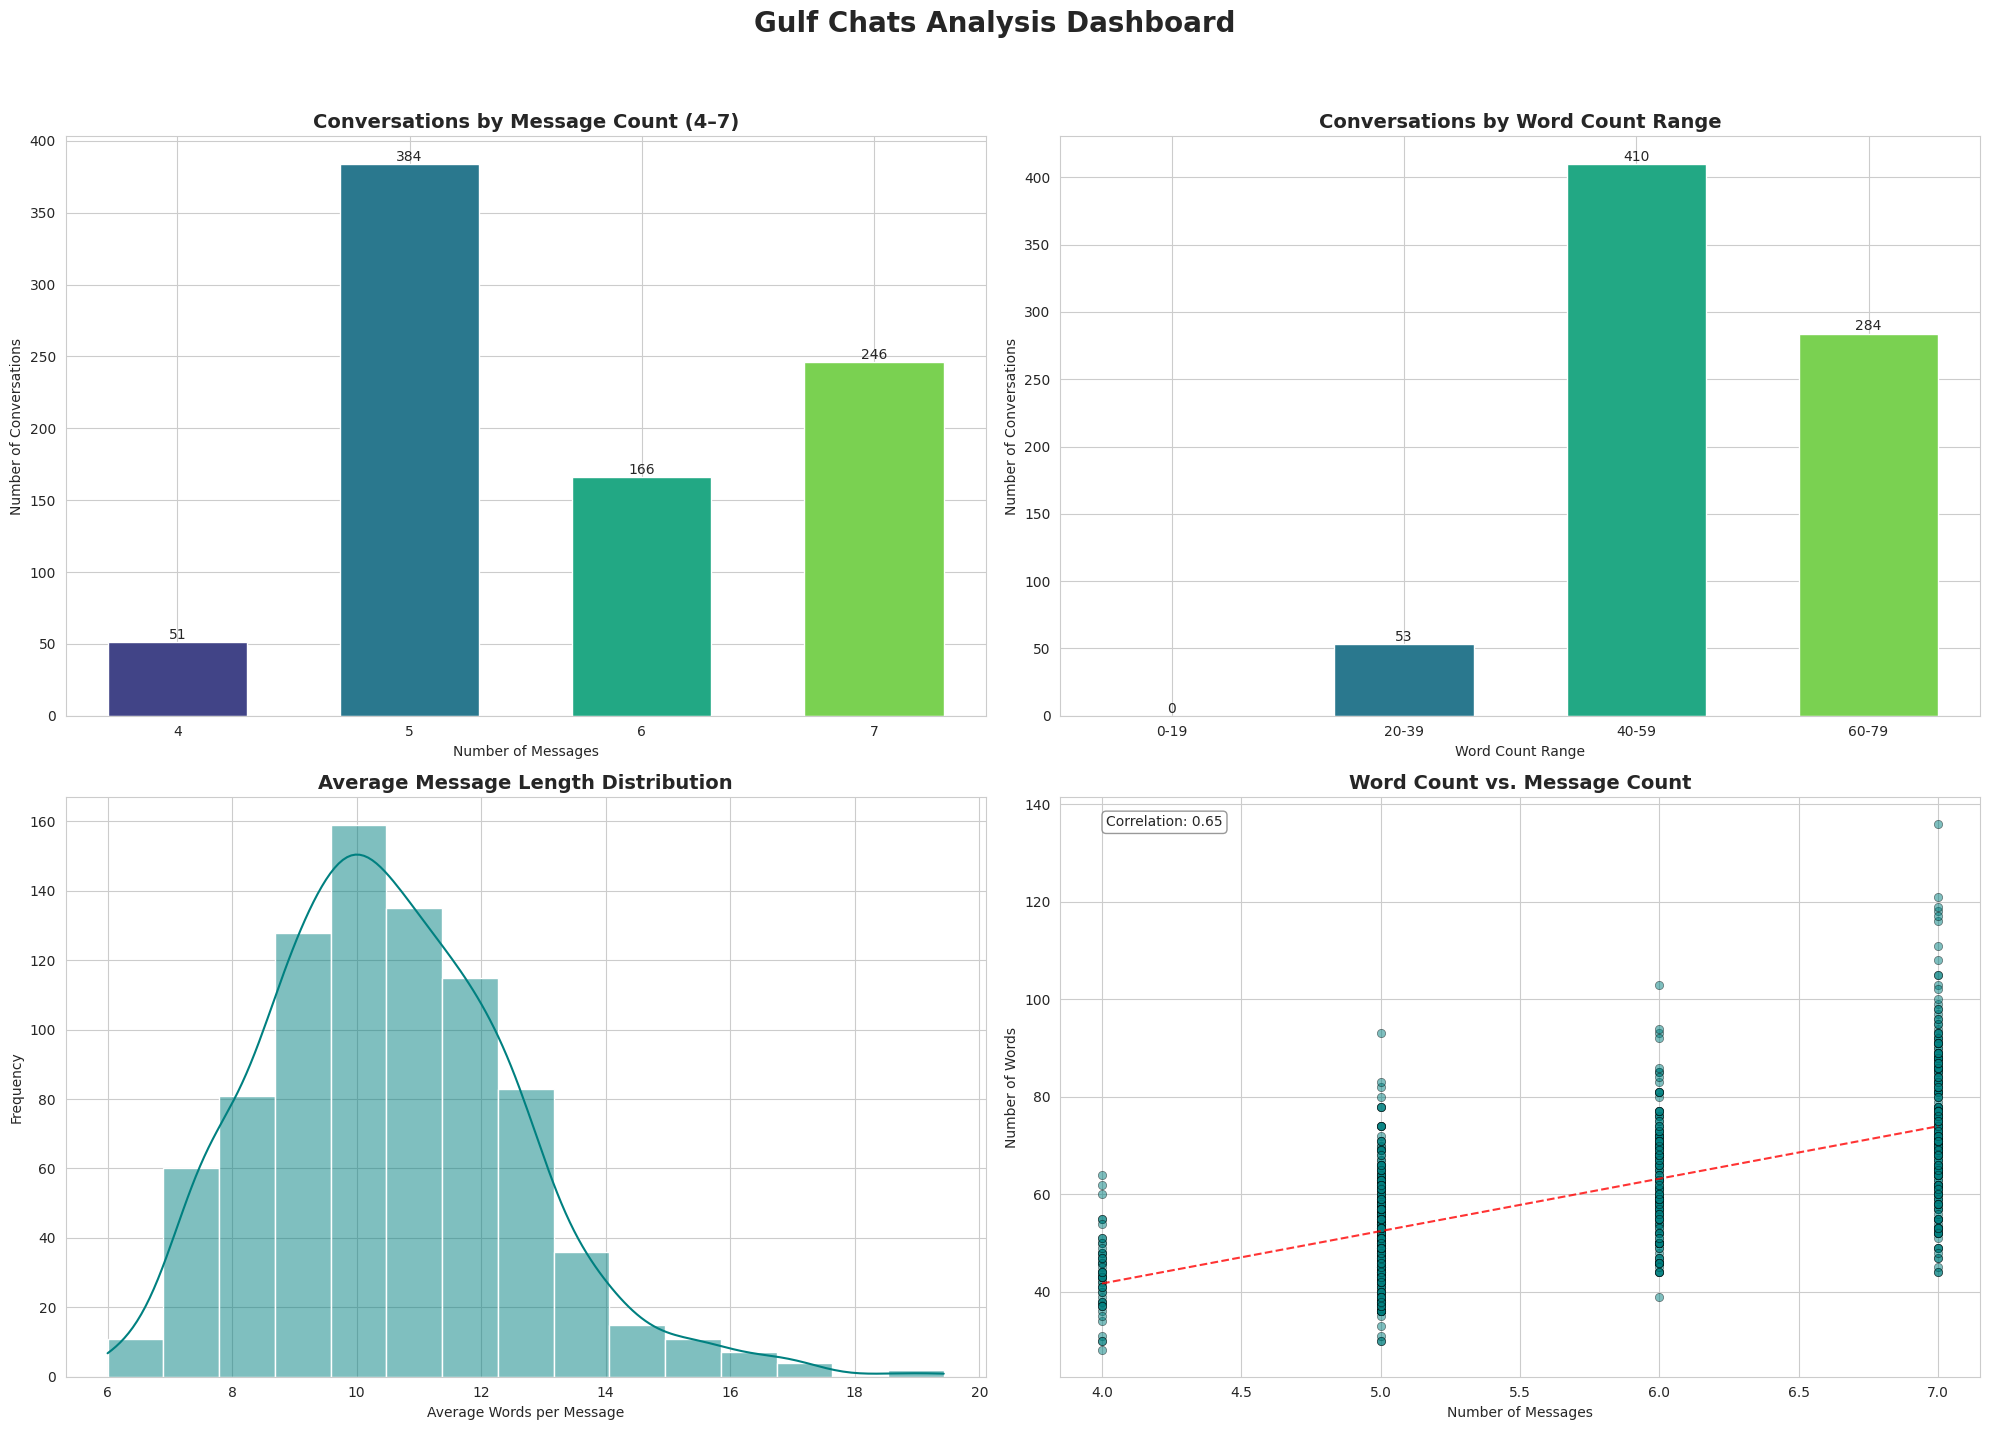

In [18]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
import re
import numpy as np
from datetime import datetime


class ChatAnalyzer:
    """
    A class to analyze chat conversations data.
    """
    
    def __init__(self, file_path=None, data=None):
        """
        Initialize the ChatAnalyzer with either a file path or data.
        
        Args:
            file_path (str, optional): Path to the JSON file containing chat data.
            data (list, optional): List of chat data dictionaries.
        """
        self.df = None
        self.output_dir = "chat_analysis_results"
        
        # Create output directory if it doesn't exist
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
            
        if file_path:
            self.load_data_from_file(file_path)
        elif data:
            self.load_data(data)
    
    def load_data_from_file(self, file_path):
        """
        Load chat data from a JSON file.
        
        Args:
            file_path (str): Path to the JSON file.
            
        Returns:
            bool: True if data was loaded successfully, False otherwise.
        """
        try:
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)
            self.load_data(data)
            print(f"Successfully loaded data from {file_path}")
            return True
        except FileNotFoundError:
            print(f"Error: File {file_path} not found")
            return False
        except json.JSONDecodeError:
            print(f"Error: Invalid JSON format in {file_path}")
            return False
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            return False
    
    def load_data(self, data):
        """
        Process loaded chat data into a DataFrame.
        
        Args:
            data (list): List of chat data dictionaries.
        """
        try:
            # Convert to DataFrame
            self.df = pd.DataFrame(data)
            
            # Calculate basic metrics
            self._calculate_basic_metrics()
            
            # Print data summary
            self._print_data_summary()
            
            return True
        except Exception as e:
            print(f"Error processing data: {str(e)}")
            return False
    
    def _calculate_basic_metrics(self):
        """Calculate basic metrics for the chat data."""
        # Number of messages per conversation
        self.df['message_count'] = self.df['messages'].apply(len)
        
        # Combine all messages into one text per conversation
        self.df['conversation_text'] = self.df['messages'].apply(lambda msgs: ' '.join(msg for msg in msgs if isinstance(msg, str)))
        
        # Calculate word count (more efficiently by splitting only once)
        self.df['word_count'] = self.df['conversation_text'].apply(lambda text: len(text.split()))
        
        # Calculate average message length
        self.df['avg_message_length'] = self.df.apply(
            lambda row: row['word_count'] / row['message_count'] if row['message_count'] > 0 else 0, 
            axis=1
        )
    
    def _print_data_summary(self):
        """Print a summary of the loaded data."""
        print("\n===== Chat Data Summary =====")
        print(f"Total conversations: {len(self.df)}")
        print(f"Average messages per conversation: {self.df['message_count'].mean():.2f}")
        print(f"Average words per conversation: {self.df['word_count'].mean():.2f}")
        print(f"Max messages in a conversation: {self.df['message_count'].max()}")
        print(f"Max words in a conversation: {self.df['word_count'].max()}")
        print("============================\n")
    
    def plot_message_count_distribution(self, min_count=None, max_count=None, save=True):
        """
        Plot the distribution of message counts.
        
        Args:
            min_count (int, optional): Minimum message count to include.
            max_count (int, optional): Maximum message count to include.
            save (bool, optional): Whether to save the plot to a file.
            
        Returns:
            matplotlib.figure.Figure: The generated figure.
        """
        # Filter data if min/max provided
        filtered_df = self.df.copy()
        if min_count is not None:
            filtered_df = filtered_df[filtered_df['message_count'] >= min_count]
        if max_count is not None:
            filtered_df = filtered_df[filtered_df['message_count'] <= max_count]
        
        # Calculate distribution
        message_dist = filtered_df['message_count'].value_counts().sort_index()
        
        # Create plot
        plt.figure(figsize=(10, 6))
        
        # Use a color palette
        color_palette = sns.color_palette("viridis", len(message_dist))
        
        bars = plt.bar(message_dist.index.astype(str), message_dist.values, 
                       color=color_palette, width=0.6)
        
        # Title with filtering information
        filter_info = ""
        if min_count is not None or max_count is not None:
            filter_info = " ("
            if min_count is not None:
                filter_info += f"{min_count}"
            else:
                filter_info += "min"
            
            filter_info += "–"
            
            if max_count is not None:
                filter_info += f"{max_count}"
            else:
                filter_info += "max"
                
            filter_info += ")"
        
        plt.title(f"Distribution of Conversations by Message Count{filter_info}", 
                  fontsize=16, fontweight='bold')
        plt.xlabel("Number of Messages", fontsize=12)
        plt.ylabel("Number of Conversations", fontsize=12)
        plt.grid(axis='y', alpha=0.3)
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{height:,}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        
        # Save figure if requested
        if save:
            filter_str = f"{min_count or 'min'}-{max_count or 'max'}"
            filename = f"{self.output_dir}/message_count_dist_{filter_str}.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Saved figure to {filename}")
        
        return plt.gcf()
    
    def plot_word_count_distribution(self, bin_size=20, max_words=None, save=True):
        """
        Plot the distribution of word counts.
        
        Args:
            bin_size (int, optional): Size of word count bins.
            max_words (int, optional): Maximum word count to include.
            save (bool, optional): Whether to save the plot to a file.
            
        Returns:
            matplotlib.figure.Figure: The generated figure.
        """
        # Filter data if max_words provided
        filtered_df = self.df.copy()
        if max_words is not None:
            filtered_df = filtered_df[filtered_df['word_count'] <= max_words]
        
        # Determine the bin range based on data and parameters
        max_bin = max_words if max_words else filtered_df['word_count'].max()
        bins = range(0, max_bin + bin_size, bin_size)
        labels = [f"{b}-{b+bin_size-1}" for b in bins[:-1]]
        
        # Create bins
        filtered_df['word_bin'] = pd.cut(filtered_df['word_count'], 
                                         bins=bins, 
                                         labels=labels, 
                                         right=False,
                                         include_lowest=True)
        
        # Calculate distribution
        word_dist = filtered_df['word_bin'].value_counts().sort_index()
        
        # Create plot
        plt.figure(figsize=(12, 6))
        
        # Use a color palette
        color_palette = sns.color_palette("viridis", len(word_dist))
        
        bars = plt.bar(word_dist.index.astype(str), word_dist.values, 
                      color=color_palette, width=0.7)
        
        plt.title(f"Distribution of Conversations by Word Count (Bin Size: {bin_size})", 
                 fontsize=16, fontweight='bold')
        plt.xlabel("Word Count Range", fontsize=12)
        plt.ylabel("Number of Conversations", fontsize=12)
        plt.grid(axis='y', alpha=0.3)
        plt.xticks(rotation=45, ha='right')
        
        # Add value labels on top of bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{height:,}', ha='center', va='bottom', fontsize=10)
        
        plt.tight_layout()
        
        # Save figure if requested
        if save:
            max_str = f"_max{max_words}" if max_words else ""
            filename = f"{self.output_dir}/word_count_dist_bin{bin_size}{max_str}.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Saved figure to {filename}")
        
        return plt.gcf()
    
    def plot_message_length_distribution(self, save=True):
        """
        Plot the distribution of average message lengths.
        
        Args:
            save (bool, optional): Whether to save the plot to a file.
            
        Returns:
            matplotlib.figure.Figure: The generated figure.
        """
        plt.figure(figsize=(10, 6))
        
        # Create histogram with KDE
        sns.histplot(self.df['avg_message_length'], kde=True, bins=20, color='teal')
        
        plt.title("Distribution of Average Message Length", 
                 fontsize=16, fontweight='bold')
        plt.xlabel("Average Words per Message", fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        
        # Save figure if requested
        if save:
            filename = f"{self.output_dir}/avg_message_length_dist.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Saved figure to {filename}")
        
        return plt.gcf()
    
    def analyze_word_frequency(self, top_n=20, min_length=3, save=True):
        """
        Analyze and plot the most frequent words in all conversations.
        
        Args:
            top_n (int, optional): Number of top words to display.
            min_length (int, optional): Minimum word length to include.
            save (bool, optional): Whether to save the plot to a file.
            
        Returns:
            matplotlib.figure.Figure: The generated figure.
        """
        # Combine all conversation texts
        all_text = ' '.join(self.df['conversation_text'])
        
        # Clean text and split into words
        words = re.findall(r'\b\w+\b', all_text.lower())
        
        # Filter words by length
        words = [word for word in words if len(word) >= min_length]
        
        # Count word frequencies
        word_counts = Counter(words)
        
        # Get top N words
        top_words = word_counts.most_common(top_n)
        
        # Create plot
        plt.figure(figsize=(12, 8))
        
        words, counts = zip(*top_words)
        y_pos = np.arange(len(words))
        
        # Create horizontal bar chart
        bars = plt.barh(y_pos, counts, align='center', 
                       color=sns.color_palette("viridis", len(words)))
        
        plt.yticks(y_pos, words)
        plt.xlabel('Frequency')
        plt.title(f'Top {top_n} Most Common Words (Min Length: {min_length})', 
                 fontsize=16, fontweight='bold')
        
        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width + 0.3, bar.get_y() + bar.get_height()/2,
                   f'{width:,}', ha='left', va='center', fontsize=10)
        
        plt.tight_layout()
        
        # Save figure if requested
        if save:
            filename = f"{self.output_dir}/word_frequency_top{top_n}_min{min_length}.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Saved figure to {filename}")
        
        return plt.gcf()
    
    def create_summary_report(self):
        """
        Create a comprehensive summary report with multiple visualizations.
        """
        # Set the style
        sns.set_style("whitegrid")
        plt.rcParams['font.family'] = 'DejaVu Sans'
        
        print("Generating summary report...")
        
        # Create a figure with subplots
        fig = plt.figure(figsize=(20, 15))
        
        # 1. Message count distribution (4-7)
        plt.subplot(2, 2, 1)
        message_dist = self.df['message_count'].value_counts().sort_index()
        filtered_msg_dist = message_dist[(message_dist.index >= 4) & (message_dist.index <= 7)]
        
        bars = plt.bar(filtered_msg_dist.index.astype(str), filtered_msg_dist.values, 
                      color=sns.color_palette("viridis", len(filtered_msg_dist)), width=0.6)
        
        plt.title("Conversations by Message Count (4–7)", fontsize=14, fontweight='bold')
        plt.xlabel("Number of Messages")
        plt.ylabel("Number of Conversations")
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{height:,}', ha='center', va='bottom', fontsize=10)
        
        # 2. Word count distribution
        plt.subplot(2, 2, 2)
        
        # Define word count bins
        bins = range(0, 100, 20)
        labels = [f"{b}-{b+19}" for b in bins[:-1]]
        
        self.df['word_bin'] = pd.cut(self.df['word_count'], bins=bins, labels=labels, right=False)
        word_dist = self.df['word_bin'].value_counts().sort_index()
        
        bars = plt.bar(word_dist.index.astype(str), word_dist.values, 
                      color=sns.color_palette("viridis", len(word_dist)), width=0.6)
        
        plt.title("Conversations by Word Count Range", fontsize=14, fontweight='bold')
        plt.xlabel("Word Count Range")
        plt.ylabel("Number of Conversations")
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{height:,}', ha='center', va='bottom', fontsize=10)
        
        # 3. Average message length distribution
        plt.subplot(2, 2, 3)
        sns.histplot(self.df['avg_message_length'], kde=True, bins=15, color='teal')
        plt.title("Average Message Length Distribution", fontsize=14, fontweight='bold')
        plt.xlabel("Average Words per Message")
        plt.ylabel("Frequency")
        
        # 4. Word count vs. message count scatter
        plt.subplot(2, 2, 4)
        plt.scatter(self.df['message_count'], self.df['word_count'], 
                   alpha=0.5, c='teal', edgecolors='k', linewidths=0.5)
        
        plt.title("Word Count vs. Message Count", fontsize=14, fontweight='bold')
        plt.xlabel("Number of Messages")
        plt.ylabel("Number of Words")
        
        # Add a trend line
        z = np.polyfit(self.df['message_count'], self.df['word_count'], 1)
        p = np.poly1d(z)
        plt.plot(np.unique(self.df['message_count']), 
                p(np.unique(self.df['message_count'])), 
                'r--', alpha=0.8)
        
        # Add correlation value
        corr = self.df[['message_count', 'word_count']].corr().iloc[0, 1]
        plt.annotate(f"Correlation: {corr:.2f}", 
                    xy=(0.05, 0.95), xycoords='axes fraction',
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
        
        # Overall title and adjustments
        plt.suptitle("Gulf Chats Analysis Dashboard", fontsize=20, fontweight='bold', y=0.98)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save the summary report
        filename = f"{self.output_dir}/summary_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Saved summary report to {filename}")
        
        return fig


# Example usage
if __name__ == "__main__":
    try:
        # Initialize the analyzer with the JSON file
        analyzer = ChatAnalyzer("gulf_chats_merged_all.json")
        
        # Generate individual plots
        analyzer.plot_message_count_distribution(min_count=4, max_count=7)
        analyzer.plot_word_count_distribution(bin_size=20, max_words=100)
        analyzer.plot_message_length_distribution()
        analyzer.analyze_word_frequency(top_n=15, min_length=4)
        
        # Generate summary report
        analyzer.create_summary_report()
        
        print("Analysis completed successfully!")
        
    except Exception as e:
        print(f"Error during analysis: {str(e)}")


Loading data from gulf_chats_merged_all.json...
Successfully loaded 847 conversations with 4842 messages
Extracting bigrams (remove_stopwords=True, min_word_length=2)...
Saved figure to chat_analysis_results/bigram_top20_nostop_min2.png
Saved data to chat_analysis_results/bigram_top20_nostop_min2.csv
Extracting bigrams (remove_stopwords=False, min_word_length=2)...
Saved figure to chat_analysis_results/bigram_top20_withstop_min2.png
Saved data to chat_analysis_results/bigram_top20_withstop_min2.csv
Saved position analysis to chat_analysis_results/bigrams_by_position_top10.png
Saved 2739 bigrams to chat_analysis_results/all_bigrams_min3_20250507_192756.csv
Bigram analysis completed successfully!


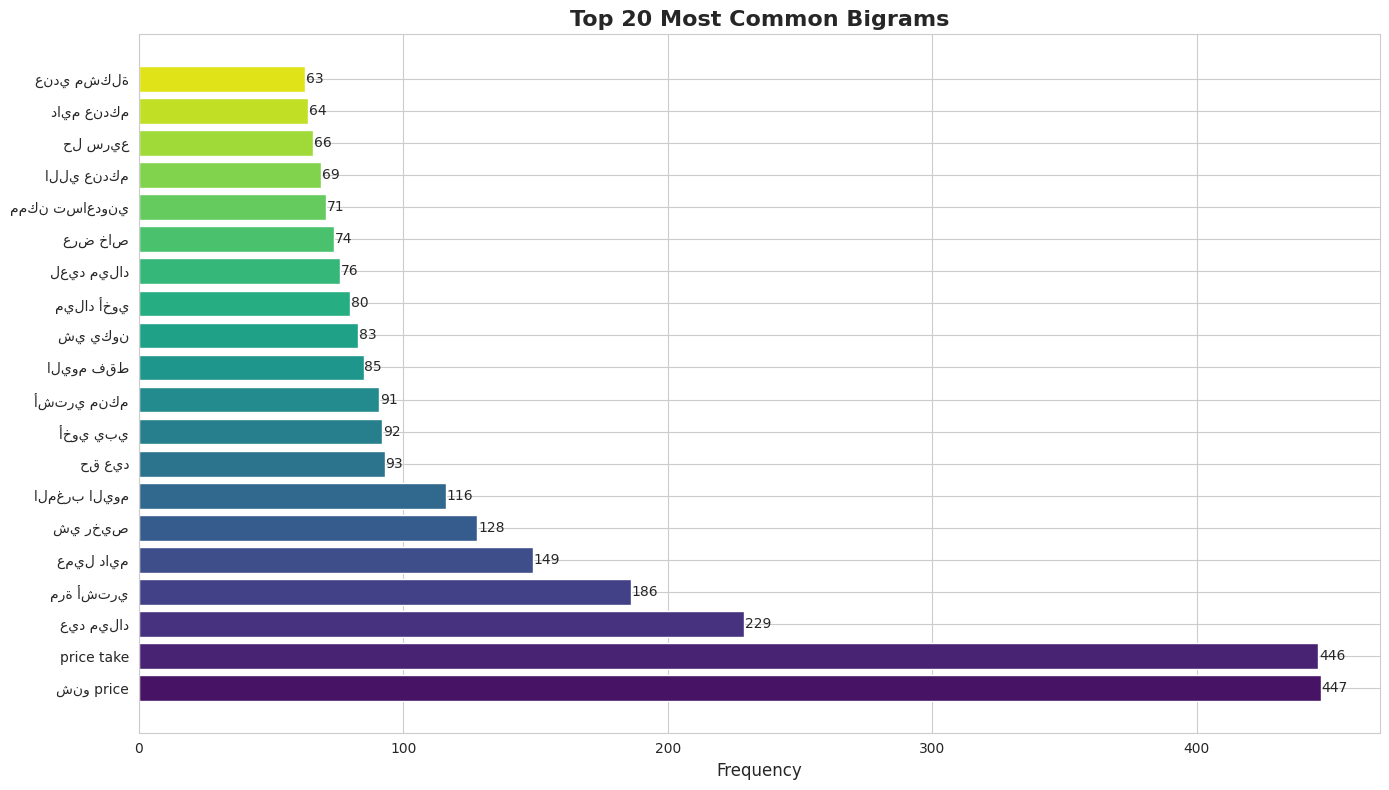

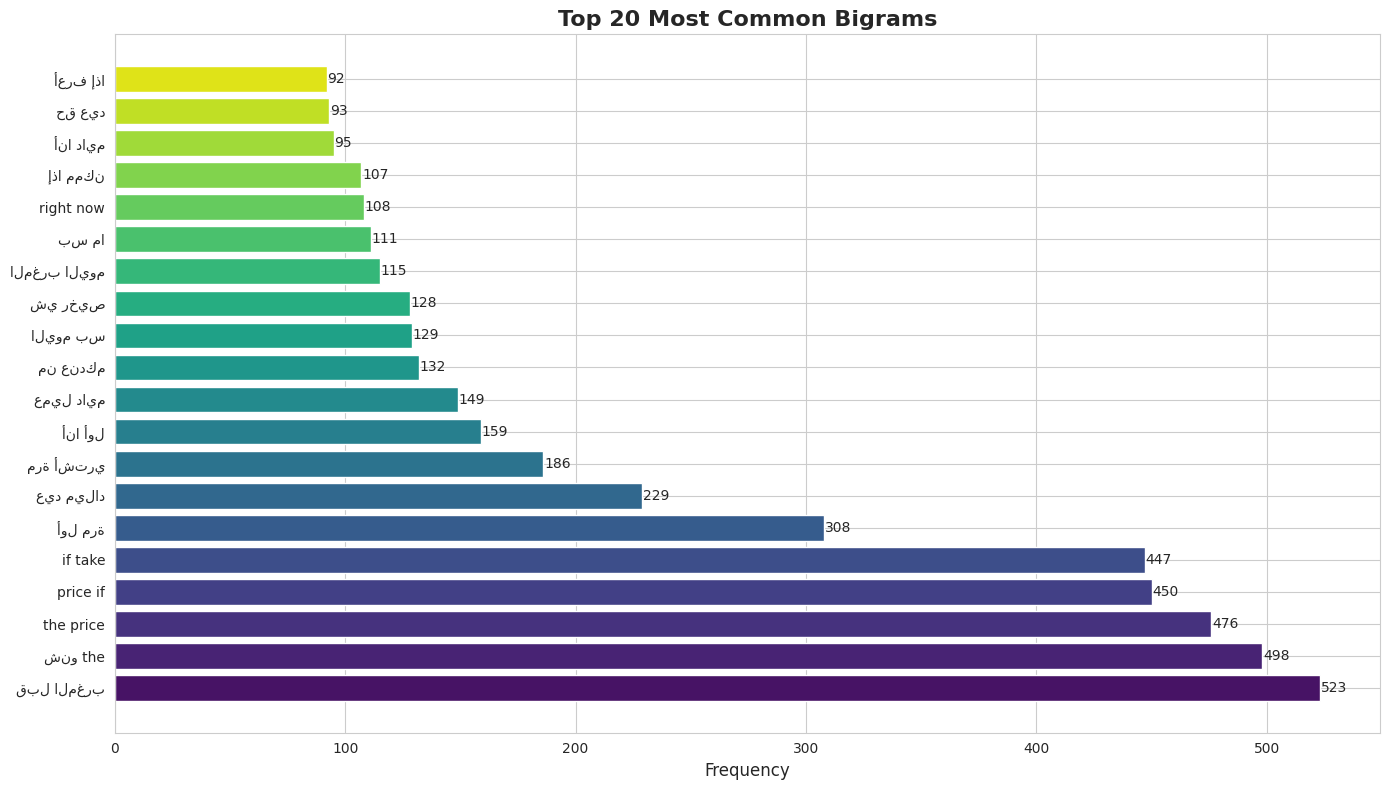

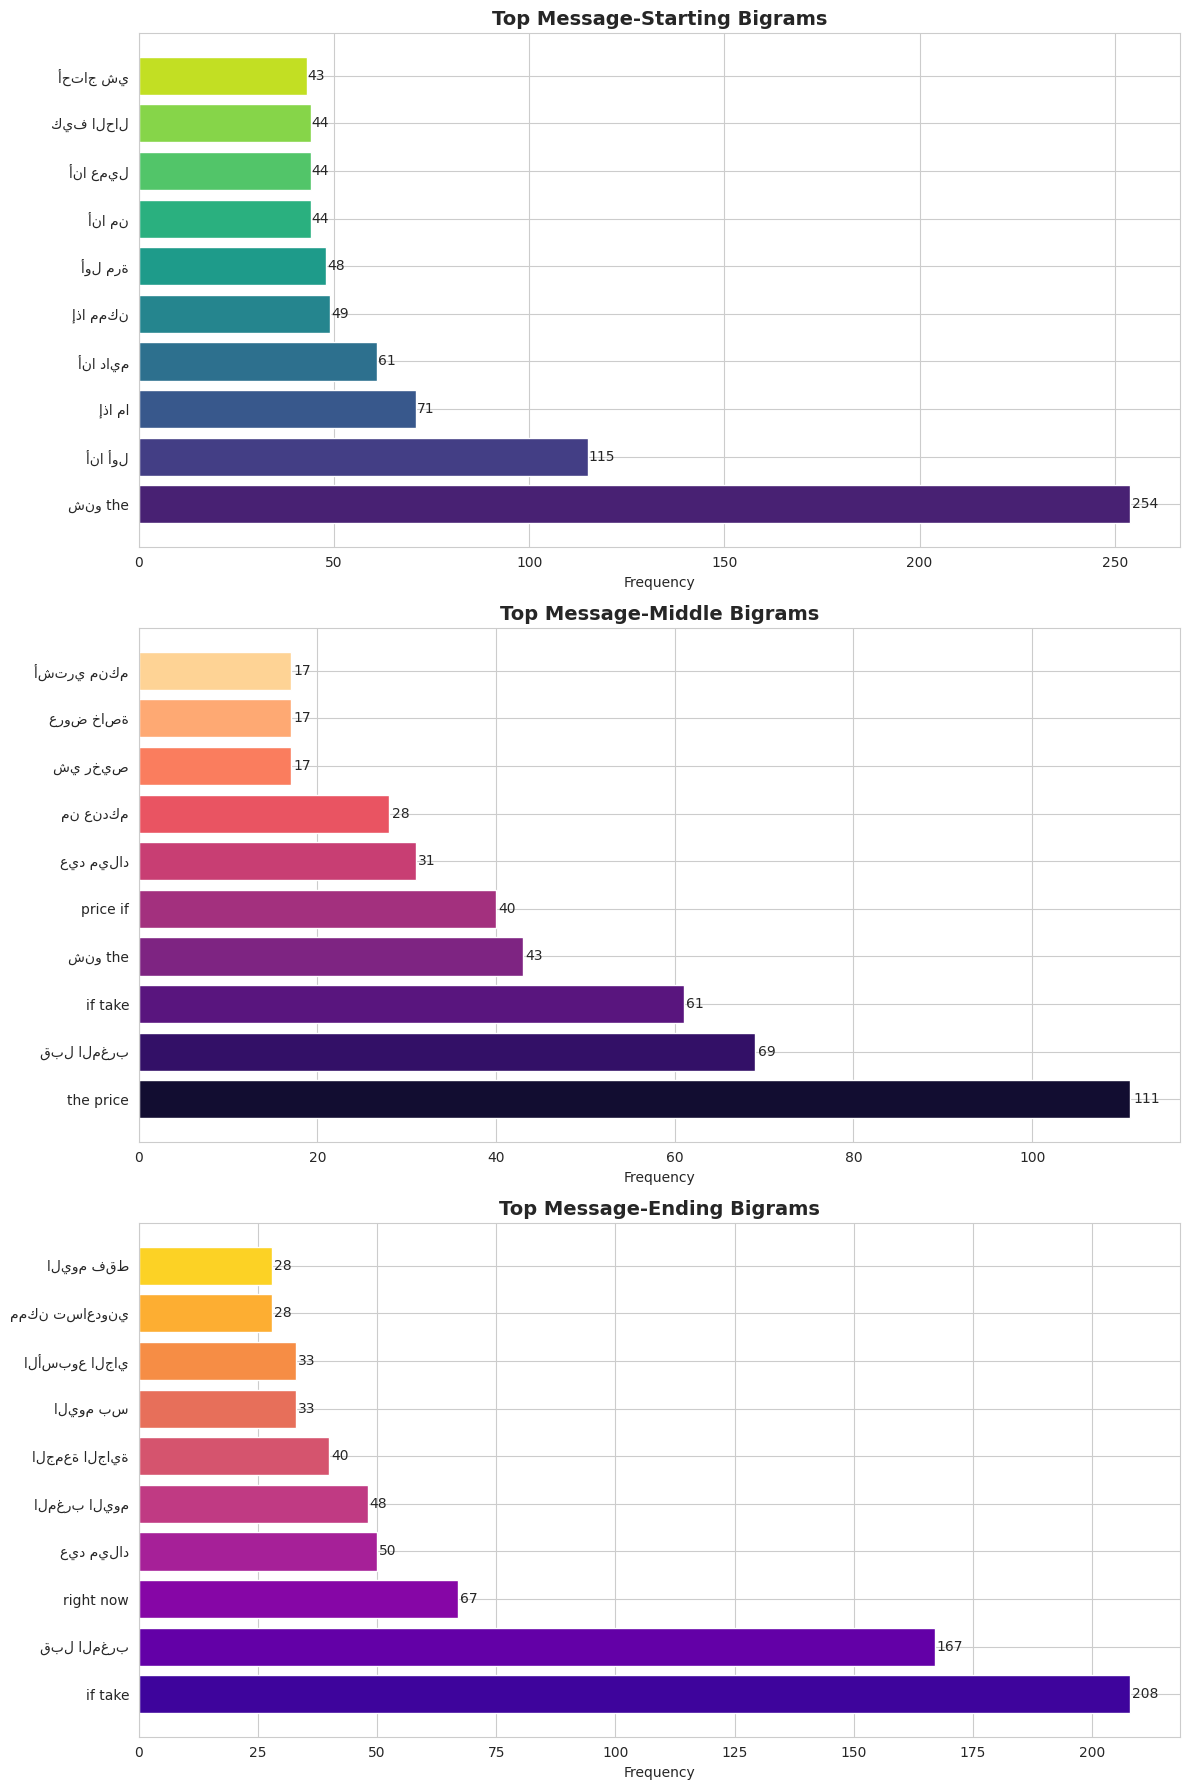

In [21]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from collections import Counter
import numpy as np
from datetime import datetime

class BigramAnalyzer:
    """
    A class to analyze bigrams (consecutive word pairs) in chat conversations.
    """
    
    def __init__(self, file_path=None, data=None):
        """
        Initialize the BigramAnalyzer with either a file path or data.
        
        Args:
            file_path (str, optional): Path to the JSON file containing chat data.
            data (list, optional): List of chat data dictionaries.
        """
        self.df = None
        self.output_dir = "chat_analysis_results"
        self.stopwords = set()
        
        # Create output directory if it doesn't exist
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
        
        # Try to download NLTK resources
        try:
            nltk.download('punkt', quiet=True)
            nltk.download('stopwords', quiet=True)
            self.stopwords = set(stopwords.words('english'))
            # Add Arabic stopwords if available
            try:
                self.stopwords.update(set(stopwords.words('arabic')))
            except:
                pass
        except:
            print("Warning: Could not download NLTK resources. Using basic tokenization instead.")
        
        if file_path:
            self.load_data_from_file(file_path)
        elif data:
            self.load_data(data)
    
    def load_data_from_file(self, file_path):
        """
        Load chat data from a JSON file.
        
        Args:
            file_path (str): Path to the JSON file.
            
        Returns:
            bool: True if data was loaded successfully, False otherwise.
        """
        try:
            print(f"Loading data from {file_path}...")
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)
            return self.load_data(data)
        except FileNotFoundError:
            print(f"Error: File {file_path} not found")
            return False
        except json.JSONDecodeError:
            print(f"Error: Invalid JSON format in {file_path}")
            return False
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            return False
    
    def load_data(self, data):
        """
        Process loaded chat data into a DataFrame.
        
        Args:
            data (list): List of chat data dictionaries.
        """
        try:
            # Convert to DataFrame
            self.df = pd.DataFrame(data)
            
            # Extract all messages into a single list
            self.all_messages = []
            for messages in self.df['messages']:
                self.all_messages.extend([msg for msg in messages if isinstance(msg, str)])
            
            print(f"Successfully loaded {len(self.df)} conversations with {len(self.all_messages)} messages")
            return True
        except Exception as e:
            print(f"Error processing data: {str(e)}")
            return False
    
    def preprocess_text(self, text, remove_stopwords=True, min_word_length=2):
        """
        Preprocess text for bigram analysis.
        
        Args:
            text (str): Input text.
            remove_stopwords (bool, optional): Whether to remove stopwords.
            min_word_length (int, optional): Minimum word length to keep.
            
        Returns:
            list: List of cleaned tokens.
        """
        # Convert to lowercase
        text = text.lower()
        
        # Remove URLs, emojis, special characters
        text = re.sub(r'http\S+', '', text)  # Remove URLs
        text = re.sub(r'[^\w\s]', ' ', text)  # Replace punctuation with space
        
        # Tokenize
        try:
            tokens = nltk.word_tokenize(text)
        except:
            # Fall back to simple splitting if NLTK not available
            tokens = text.split()
        
        # Filter tokens
        filtered_tokens = []
        for token in tokens:
            # Skip if token is too short
            if len(token) < min_word_length:
                continue
                
            # Skip if token is a stopword
            if remove_stopwords and token in self.stopwords:
                continue
                
            # Skip if token contains digits
            if any(c.isdigit() for c in token):
                continue
                
            filtered_tokens.append(token)
            
        return filtered_tokens
    
    def extract_bigrams(self, remove_stopwords=True, min_word_length=2):
        """
        Extract bigrams from all messages.
        
        Args:
            remove_stopwords (bool, optional): Whether to remove stopwords.
            min_word_length (int, optional): Minimum word length to keep.
            
        Returns:
            list: List of bigrams.
        """
        all_bigrams = []
        
        for message in self.all_messages:
            tokens = self.preprocess_text(
                message, 
                remove_stopwords=remove_stopwords,
                min_word_length=min_word_length
            )
            
            # Skip if not enough tokens for a bigram
            if len(tokens) < 2:
                continue
                
            # Generate bigrams
            message_bigrams = list(ngrams(tokens, 2))
            all_bigrams.extend(message_bigrams)
            
        return all_bigrams
    
    def analyze_top_bigrams(self, top_n=20, remove_stopwords=True, min_word_length=2, save=True):
        """
        Analyze and plot top bigrams.
        
        Args:
            top_n (int, optional): Number of top bigrams to display.
            remove_stopwords (bool, optional): Whether to remove stopwords.
            min_word_length (int, optional): Minimum word length to keep.
            save (bool, optional): Whether to save the plot to a file.
            
        Returns:
            tuple: (Counter of bigrams, matplotlib figure)
        """
        print(f"Extracting bigrams (remove_stopwords={remove_stopwords}, min_word_length={min_word_length})...")
        
        # Extract bigrams
        bigrams = self.extract_bigrams(
            remove_stopwords=remove_stopwords,
            min_word_length=min_word_length
        )
        
        if not bigrams:
            print("No bigrams found with the current settings")
            return None, None
            
        # Count frequencies
        bigram_counts = Counter(bigrams)
        
        # Get top N bigrams
        top_bigrams = bigram_counts.most_common(top_n)
        
        # Create labels for plot
        labels = [f"{b[0]} {b[1]}" for b, _ in top_bigrams]
        counts = [count for _, count in top_bigrams]
        
        # Plot results
        plt.figure(figsize=(14, 8))
        
        bars = plt.barh(range(len(counts)), counts, align='center', 
                       color=sns.color_palette("viridis", len(counts)))
        
        plt.yticks(range(len(counts)), labels)
        plt.xlabel('Frequency', fontsize=12)
        plt.title(f'Top {top_n} Most Common Bigrams', fontsize=16, fontweight='bold')
        
        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width + 0.3, bar.get_y() + bar.get_height()/2,
                   f'{width:,}', ha='left', va='center', fontsize=10)
        
        plt.tight_layout()
        
        # Save figure if requested
        if save:
            stopwords_str = "nostop" if remove_stopwords else "withstop"
            filename = f"{self.output_dir}/bigram_top{top_n}_{stopwords_str}_min{min_word_length}.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Saved figure to {filename}")
            
            # Also save data to CSV
            csv_filename = f"{self.output_dir}/bigram_top{top_n}_{stopwords_str}_min{min_word_length}.csv"
            with open(csv_filename, 'w', encoding='utf-8') as f:
                f.write("bigram,count\n")
                for (w1, w2), count in top_bigrams:
                    f.write(f"\"{w1} {w2}\",{count}\n")
            print(f"Saved data to {csv_filename}")
        
        return bigram_counts, plt.gcf()
    
    def analyze_bigram_contexts(self, bigram, window=5, max_examples=10):
        """
        Analyze the context in which a specific bigram appears.
        
        Args:
            bigram (tuple): The bigram to analyze, e.g., ('hello', 'world').
            window (int, optional): Context window size (words before/after).
            max_examples (int, optional): Maximum number of examples to show.
            
        Returns:
            list: Context examples for the bigram.
        """
        if not isinstance(bigram, tuple) or len(bigram) != 2:
            print("Error: Bigram must be a tuple of two words")
            return []
            
        bigram_lower = (bigram[0].lower(), bigram[1].lower())
        contexts = []
        
        for message in self.all_messages:
            tokens = message.lower().split()
            
            # Find bigram occurrences
            for i in range(len(tokens) - 1):
                if (tokens[i], tokens[i+1]) == bigram_lower:
                    # Extract context
                    start = max(0, i - window)
                    end = min(len(tokens), i + 2 + window)
                    context = ' '.join(tokens[start:end])
                    contexts.append(context)
                    
                    if len(contexts) >= max_examples:
                        break
                        
            if len(contexts) >= max_examples:
                break
                
        return contexts
    
    def analyze_bigrams_by_position(self, top_n=10, save=True):
        """
        Analyze top bigrams at the beginning, middle, and end of messages.
        
        Args:
            top_n (int): Number of top bigrams to analyze for each position.
            save (bool): Whether to save the results.
            
        Returns:
            dict: Dictionary with top bigrams by position.
        """
        beginning_bigrams = []
        middle_bigrams = []
        end_bigrams = []
        
        for message in self.all_messages:
            tokens = self.preprocess_text(message, remove_stopwords=False)
            
            if len(tokens) < 2:
                continue
                
            # Beginning bigrams (first two tokens)
            beginning_bigrams.append(tuple(tokens[:2]))
            
            # End bigrams (last two tokens)
            end_bigrams.append(tuple(tokens[-2:]))
            
            # Middle bigrams (if message is long enough)
            if len(tokens) >= 4:
                mid_index = len(tokens) // 2 - 1
                middle_bigrams.append((tokens[mid_index], tokens[mid_index + 1]))
        
        # Count frequencies
        beginning_counts = Counter(beginning_bigrams).most_common(top_n)
        middle_counts = Counter(middle_bigrams).most_common(top_n)
        end_counts = Counter(end_bigrams).most_common(top_n)
        
        # Create figure with subplots
        fig, axes = plt.subplots(3, 1, figsize=(12, 18))
        
        # Plot beginning bigrams
        self._plot_bigrams_on_axis(beginning_counts, axes[0], 
                                  "Top Message-Starting Bigrams", 
                                  "viridis")
        
        # Plot middle bigrams
        self._plot_bigrams_on_axis(middle_counts, axes[1], 
                                  "Top Message-Middle Bigrams", 
                                  "magma")
        
        # Plot end bigrams
        self._plot_bigrams_on_axis(end_counts, axes[2], 
                                  "Top Message-Ending Bigrams", 
                                  "plasma")
        
        plt.tight_layout()
        
        # Save figure if requested
        if save:
            filename = f"{self.output_dir}/bigrams_by_position_top{top_n}.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Saved position analysis to {filename}")
        
        return {
            "beginning": beginning_counts,
            "middle": middle_counts,
            "end": end_counts
        }
    
    def _plot_bigrams_on_axis(self, bigram_counts, ax, title, cmap):
        """Helper method to plot bigrams on a specific axis."""
        if not bigram_counts:
            ax.text(0.5, 0.5, "No data available", 
                   ha='center', va='center', fontsize=14)
            ax.set_title(title)
            return
            
        # Create labels and counts
        labels = [f"{b[0]} {b[1]}" for b, _ in bigram_counts]
        counts = [count for _, count in bigram_counts]
        
        # Plot horizontal bars
        bars = ax.barh(range(len(counts)), counts, align='center',
                      color=sns.color_palette(cmap, len(counts)))
        
        ax.set_yticks(range(len(counts)))
        ax.set_yticklabels(labels)
        ax.set_xlabel('Frequency')
        ax.set_title(title, fontsize=14, fontweight='bold')
        
        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width + 0.3, bar.get_y() + bar.get_height()/2,
                   f'{width:,}', ha='left', va='center', fontsize=10)
    
    def save_all_bigrams(self, min_count=2, filename=None):
        """
        Save all bigrams with their counts to a CSV file.
        
        Args:
            min_count (int): Minimum count to include a bigram.
            filename (str, optional): Custom filename for the CSV.
            
        Returns:
            str: Path to the saved file.
        """
        # Extract all bigrams
        bigrams = self.extract_bigrams(remove_stopwords=False, min_word_length=1)
        
        if not bigrams:
            print("No bigrams found")
            return None
            
        # Count frequencies
        bigram_counts = Counter(bigrams)
        
        # Filter by minimum count
        filtered_bigrams = {b: c for b, c in bigram_counts.items() if c >= min_count}
        
        # Sort by count (descending)
        sorted_bigrams = sorted(filtered_bigrams.items(), key=lambda x: x[1], reverse=True)
        
        # Generate filename
        if filename is None:
            filename = f"{self.output_dir}/all_bigrams_min{min_count}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        
        # Save to CSV
        with open(filename, 'w', encoding='utf-8') as f:
            f.write("first_word,second_word,bigram,count\n")
            for (w1, w2), count in sorted_bigrams:
                f.write(f"\"{w1}\",\"{w2}\",\"{w1} {w2}\",{count}\n")
        
        print(f"Saved {len(sorted_bigrams)} bigrams to {filename}")
        return filename


# Example usage
if __name__ == "__main__":
    try:
        # Initialize the analyzer with the JSON file
        analyzer = BigramAnalyzer("gulf_chats_merged_all.json")
        
        # Analyze top bigrams (with and without stopwords)
        analyzer.analyze_top_bigrams(top_n=20, remove_stopwords=True)
        analyzer.analyze_top_bigrams(top_n=20, remove_stopwords=False)
        
        # Analyze bigrams by position in messages
        analyzer.analyze_bigrams_by_position(top_n=10)
        
        # Save comprehensive bigram data
        analyzer.save_all_bigrams(min_count=3)
        
        # Example: Find contexts for a specific bigram
        # If you know a specific bigram of interest, uncomment and modify:
        # contexts = analyzer.analyze_bigram_contexts(('thank', 'you'), window=5)
        # for i, context in enumerate(contexts, 1):
        #     print(f"{i}. {context}")
        
        print("Bigram analysis completed successfully!")
        
    except Exception as e:
        print(f"Error during analysis: {str(e)}")

Using font: ['Arial'] for Arabic text
Loaded 705 stopwords
Loading data from gulf_chats_merged_all.json...
Successfully loaded 847 conversations with 4842 messages
Extracting bigrams (remove_stopwords=True, min_word_length=2)...
Saved figure to chat_analysis_results/bigram_top20_nostop_min2.png
Saved data to chat_analysis_results/bigram_top20_nostop_min2.csv
Extracting bigrams (remove_stopwords=False, min_word_length=2)...
Saved figure to chat_analysis_results/bigram_top20_withstop_min2.png
Saved data to chat_analysis_results/bigram_top20_withstop_min2.csv
Saved position analysis to chat_analysis_results/bigrams_by_position_top10.png
Saved 2604 bigrams to chat_analysis_results/all_bigrams_min3_20250507_193649.csv
Bigram analysis completed successfully!


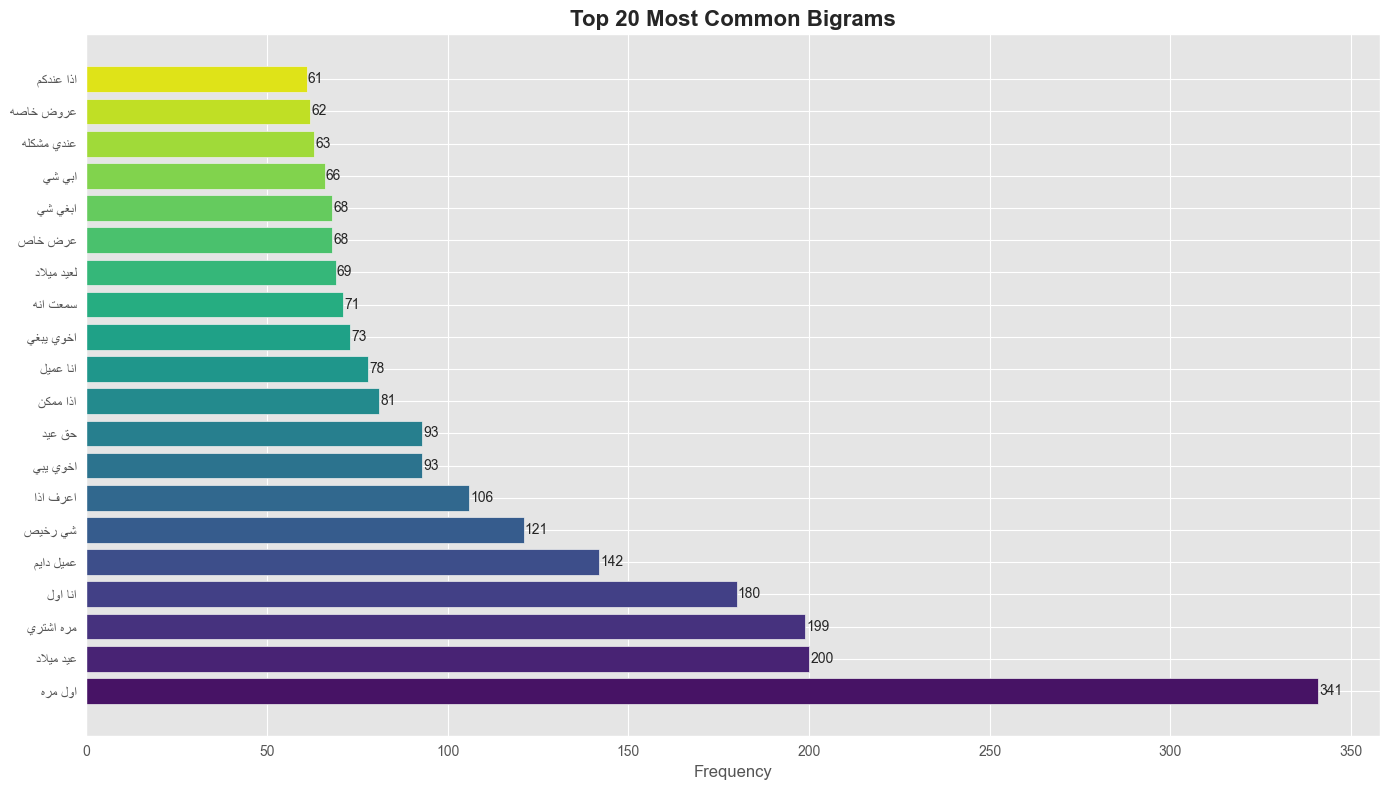

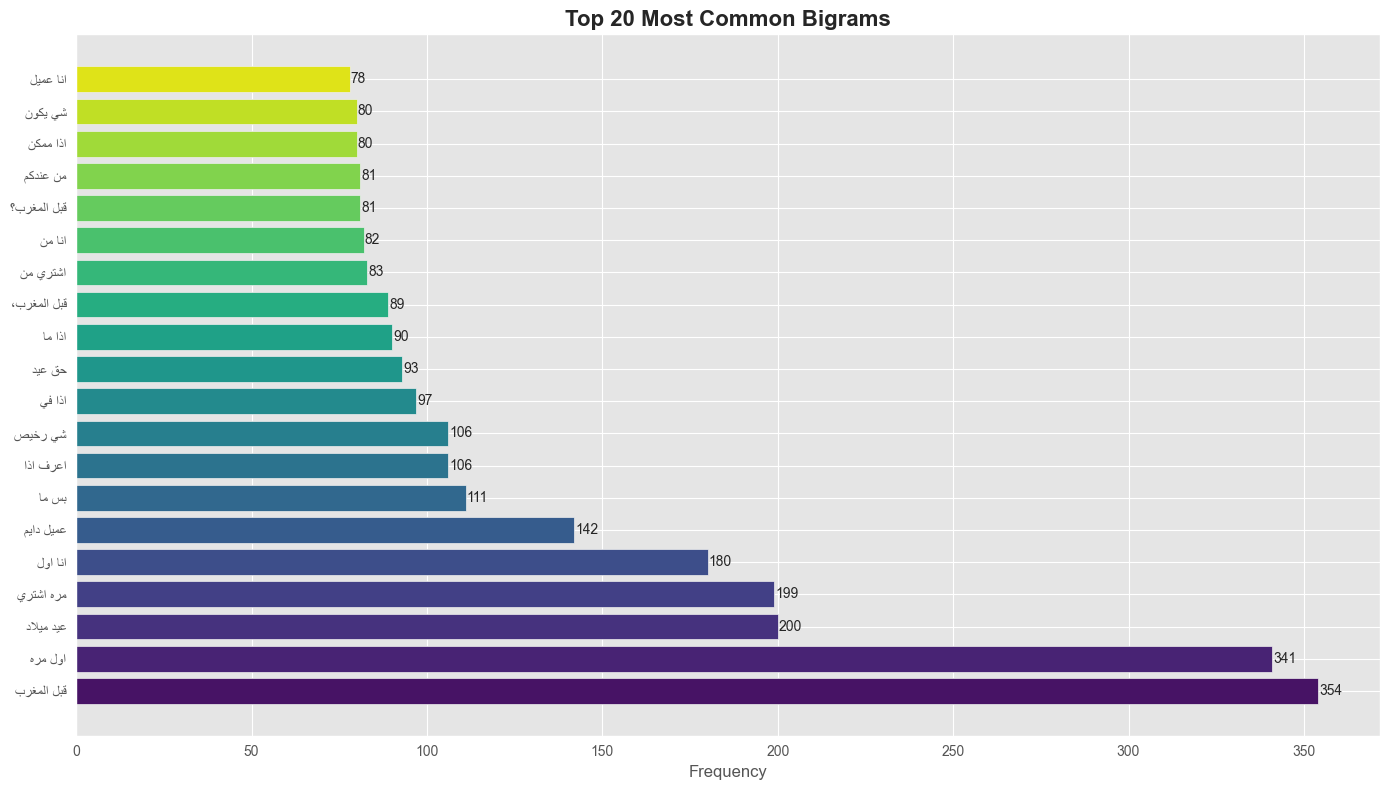

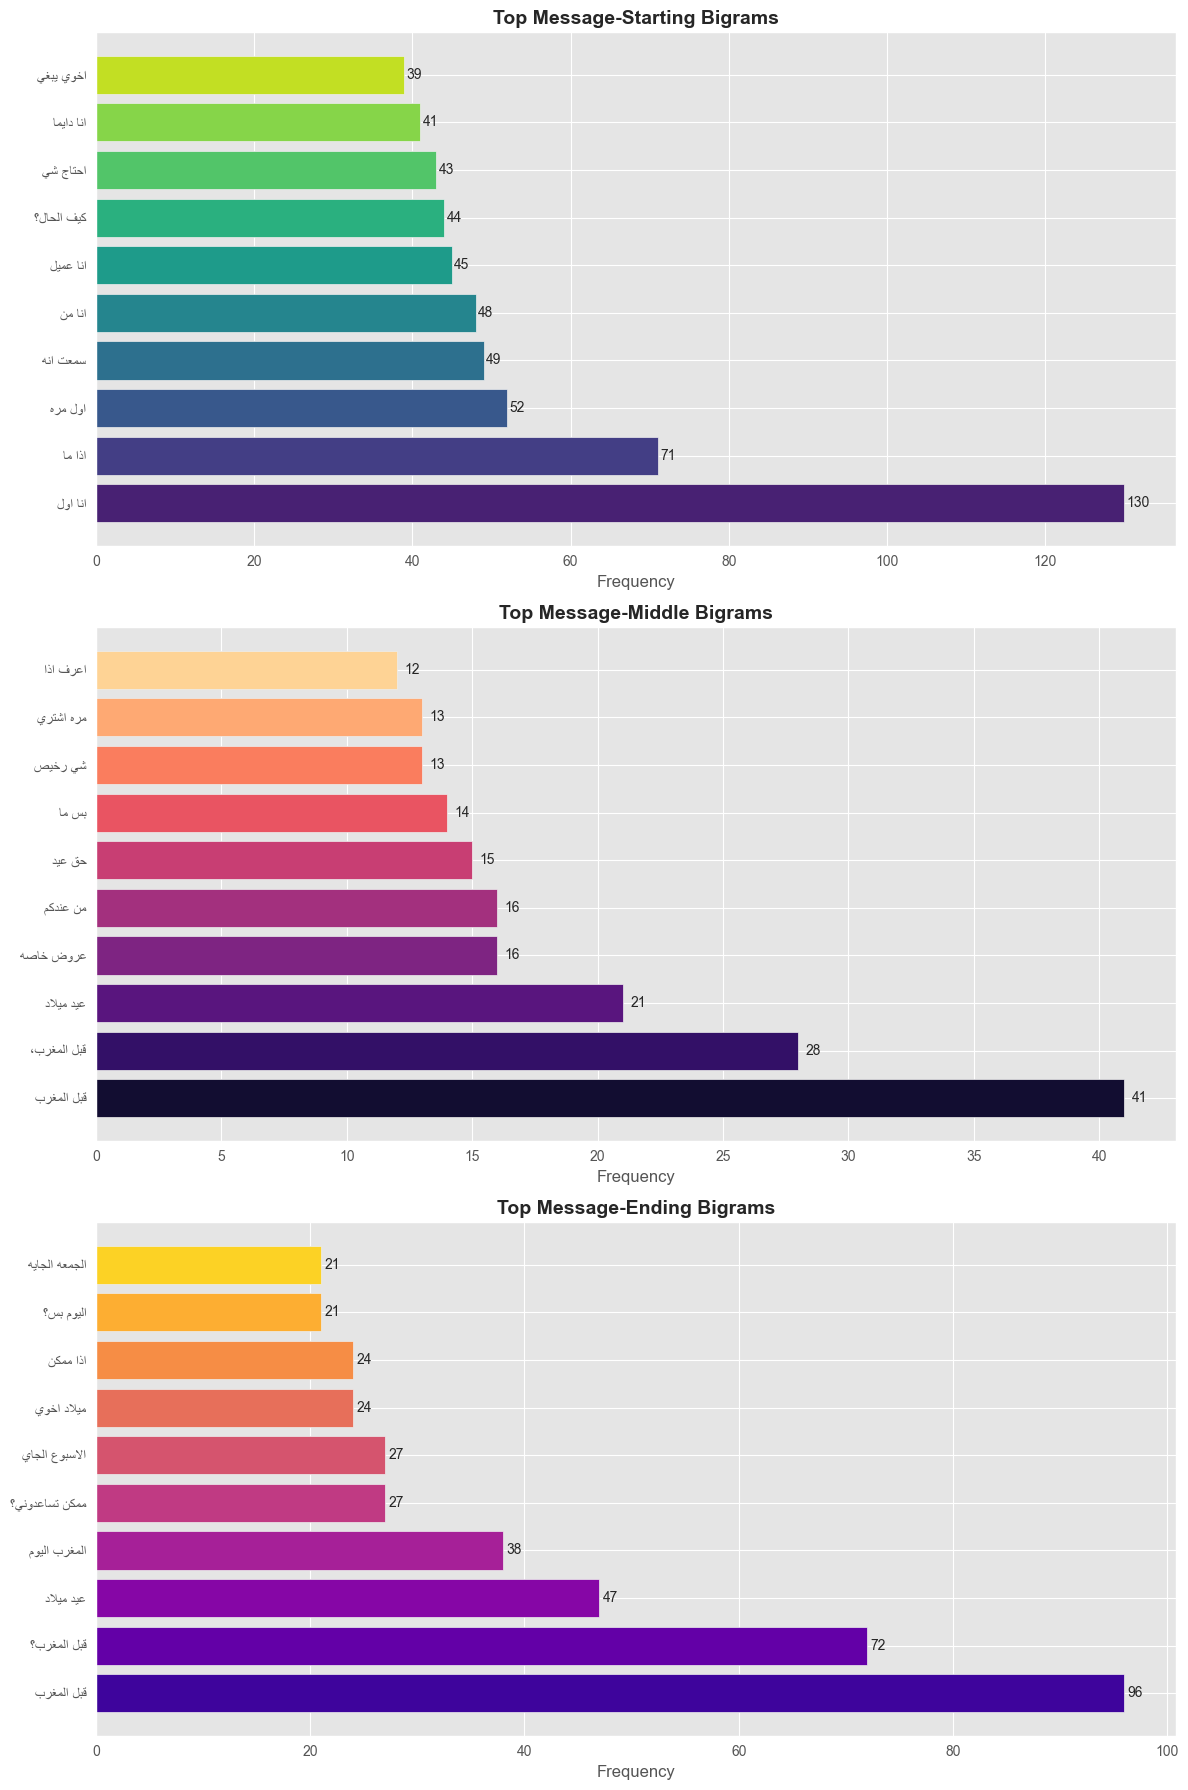

In [23]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
from collections import Counter
import numpy as np
from datetime import datetime
import bidi.algorithm as bidi  # Add support for bidirectional text
import arabic_reshaper  # For proper Arabic text reshaping
from io import BytesIO
import matplotlib.font_manager as fm  # For font management
import unicodedata

class BigramAnalyzer:
    """
    A class to analyze bigrams (consecutive word pairs) in chat conversations,
    with enhanced support for Arabic text.
    """
    
    def __init__(self, file_path=None, data=None, language='arabic'):
        """
        Initialize the BigramAnalyzer with either a file path or data.
        
        Args:
            file_path (str, optional): Path to the JSON file containing chat data.
            data (list, optional): List of chat data dictionaries.
            language (str, optional): Primary language for analysis ('arabic' or 'english').
        """
        self.df = None
        self.output_dir = "chat_analysis_results"
        self.stopwords = set()
        self.language = language.lower()
        
        # Set up matplotlib for RTL languages if needed
        if self.language == 'arabic':
            plt.rcParams['axes.unicode_minus'] = False
            
            # Try to find a font that supports Arabic
            arabic_fonts = [f for f in fm.findSystemFonts() 
                           if any(name in f.lower() for name in 
                                 ['arabic', 'noto', 'amiri', 'scheherazade', 'tahoma', 'arial'])]
            
            if arabic_fonts:
                # Use the first matching font
                plt.rcParams['font.family'] = fm.FontProperties(fname=arabic_fonts[0]).get_name()
                print(f"Using font: {plt.rcParams['font.family']} for Arabic text")
            else:
                print("Warning: No suitable Arabic font found. Text may not display correctly.")
        
        # Create output directory if it doesn't exist
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
        
        # Try to download NLTK resources
        try:
            nltk.download('punkt', quiet=True)
            nltk.download('stopwords', quiet=True)
            
            # Load primary language stopwords
            if self.language == 'arabic':
                self.load_arabic_stopwords()
            else:
                self.stopwords = set(stopwords.words('english'))
                # Add Arabic stopwords if needed
                try:
                    self.stopwords.update(set(stopwords.words('arabic')))
                except:
                    self.load_arabic_stopwords()
                    
        except Exception as e:
            print(f"Warning: Could not download NLTK resources: {str(e)}. Using basic tokenization instead.")
        
        if file_path:
            self.load_data_from_file(file_path)
        elif data:
            self.load_data(data)
    
    def load_arabic_stopwords(self):
        """Load Arabic stopwords from multiple sources for better coverage."""
        # Try NLTK first
        try:
            self.stopwords.update(set(stopwords.words('arabic')))
        except:
            print("Could not load Arabic stopwords from NLTK")
            
        # Add common Arabic stopwords manually as fallback
        common_arabic_stopwords = {
            'من', 'إلى', 'في', 'على', 'عن', 'مع', 'هذا', 'هذه', 'تلك', 'ذلك',
            'أنا', 'نحن', 'أنت', 'أنتم', 'هو', 'هي', 'هم', 'كان', 'كانت', 
            'يكون', 'الذي', 'التي', 'الذين', 'ما', 'لا', 'لم', 'لن', 'و', 'أو',
            'ثم', 'إن', 'أن', 'إذا', 'كما', 'بعد', 'قبل', 'حتى', 'عندما',
            'أي', 'كل', 'بعض', 'غير', 'مثل', 'بين', 'فوق', 'تحت', 'هناك',
            'كيف', 'متى', 'لماذا', 'ماذا', 'أين'
        }
        self.stopwords.update(common_arabic_stopwords)
        print(f"Loaded {len(self.stopwords)} stopwords")
    
    def load_data_from_file(self, file_path):
        """
        Load chat data from a JSON file.
        
        Args:
            file_path (str): Path to the JSON file.
            
        Returns:
            bool: True if data was loaded successfully, False otherwise.
        """
        try:
            print(f"Loading data from {file_path}...")
            with open(file_path, "r", encoding="utf-8") as f:
                data = json.load(f)
            return self.load_data(data)
        except FileNotFoundError:
            print(f"Error: File {file_path} not found")
            return False
        except json.JSONDecodeError:
            print(f"Error: Invalid JSON format in {file_path}")
            return False
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            return False
    
    def load_data(self, data):
        """
        Process loaded chat data into a DataFrame.
        
        Args:
            data (list): List of chat data dictionaries.
        """
        try:
            # Convert to DataFrame
            self.df = pd.DataFrame(data)
            
            # Extract all messages into a single list
            self.all_messages = []
            for messages in self.df['messages']:
                self.all_messages.extend([msg for msg in messages if isinstance(msg, str)])
            
            print(f"Successfully loaded {len(self.df)} conversations with {len(self.all_messages)} messages")
            return True
        except Exception as e:
            print(f"Error processing data: {str(e)}")
            return False
    
    def normalize_arabic_text(self, text):
        """
        Normalize Arabic text by removing diacritics and normalizing letter forms.
        
        Args:
            text (str): Input Arabic text.
            
        Returns:
            str: Normalized Arabic text.
        """
        # Remove diacritics (tashkeel)
        text = re.sub(r'[\u064B-\u065F]', '', text)
        
        # Normalize alef forms to plain alef
        text = re.sub(r'[إأآا]', 'ا', text)
        
        # Normalize ya and alef maksura
        text = re.sub(r'[يى]', 'ي', text)
        
        # Normalize hamzas on carriers to hamza
        text = re.sub(r'[ؤئ]', 'ء', text)
        
        # Normalize ta marbuta to ha
        text = re.sub(r'ة', 'ه', text)
        
        return text
    
    def is_arabic_string(self, s):
        """Check if string contains Arabic characters."""
        arabic_pattern = re.compile(r'[\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF]+')
        return bool(arabic_pattern.search(s))
    
    def preprocess_text(self, text, remove_stopwords=True, min_word_length=2):
        """
        Preprocess text for bigram analysis with enhanced Arabic support.
        
        Args:
            text (str): Input text.
            remove_stopwords (bool, optional): Whether to remove stopwords.
            min_word_length (int, optional): Minimum word length to keep.
            
        Returns:
            list: List of cleaned tokens.
        """
        has_arabic = self.is_arabic_string(text)
        
        # Skip empty text
        if not text:
            return []
        
        # Convert to lowercase for non-Arabic text
        if not has_arabic:
            text = text.lower()
        else:
            # Normalize Arabic text
            text = self.normalize_arabic_text(text)
        
        # Remove URLs, emojis, special characters
        text = re.sub(r'http\S+', '', text)  # Remove URLs
        
        # For Arabic, keep Arabic punctuation but remove others
        if has_arabic:
            # Remove non-Arabic characters and keep Arabic punctuation
            text = re.sub(r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\uFB50-\uFDFF\uFE70-\uFEFF\s]', ' ', text)
        else:
            # For non-Arabic, replace punctuation with space
            text = re.sub(r'[^\w\s]', ' ', text)
        
        # Tokenize
        if has_arabic:
            # Simple whitespace tokenization for Arabic (often works better than NLTK for Arabic)
            tokens = text.split()
            
            # Try Arabic-specific tokenizer if available
            try:
                import pyarabic.araby as araby
                tokens = araby.tokenize(text)
            except ImportError:
                pass
        else:
            try:
                tokens = nltk.word_tokenize(text)
            except:
                # Fall back to simple splitting if NLTK not available
                tokens = text.split()
        
        # Filter tokens
        filtered_tokens = []
        for token in tokens:
            # Skip if token is too short
            if len(token) < min_word_length:
                continue
                
            # Skip if token is a stopword
            if remove_stopwords and token in self.stopwords:
                continue
                
            # Skip if token contains digits (keep for Arabic if it's mixed with Arabic letters)
            if not has_arabic and any(c.isdigit() for c in token):
                continue
            elif has_arabic and token.isdigit():
                continue
                
            filtered_tokens.append(token)
            
        return filtered_tokens
    
    def reshape_arabic_for_display(self, text):
        """
        Reshape Arabic text for proper display in matplotlib.
        
        Args:
            text (str): Input text containing Arabic.
            
        Returns:
            str: Reshaped text for display.
        """
        try:
            # Reshape Arabic text
            reshaped_text = arabic_reshaper.reshape(text)
            # Handle bidirectional text
            bidi_text = bidi.get_display(reshaped_text)
            return bidi_text
        except:
            # If reshaping fails, return original
            print(f"Warning: Failed to reshape text: {text}")
            return text
    
    def extract_bigrams(self, remove_stopwords=True, min_word_length=2):
        """
        Extract bigrams from all messages.
        
        Args:
            remove_stopwords (bool, optional): Whether to remove stopwords.
            min_word_length (int, optional): Minimum word length to keep.
            
        Returns:
            list: List of bigrams.
        """
        all_bigrams = []
        
        for message in self.all_messages:
            tokens = self.preprocess_text(
                message, 
                remove_stopwords=remove_stopwords,
                min_word_length=min_word_length
            )
            
            # Skip if not enough tokens for a bigram
            if len(tokens) < 2:
                continue
                
            # Generate bigrams
            message_bigrams = list(ngrams(tokens, 2))
            all_bigrams.extend(message_bigrams)
            
        return all_bigrams
    
    def analyze_top_bigrams(self, top_n=20, remove_stopwords=True, min_word_length=2, save=True):
        """
        Analyze and plot top bigrams with enhanced Arabic support.
        
        Args:
            top_n (int, optional): Number of top bigrams to display.
            remove_stopwords (bool, optional): Whether to remove stopwords.
            min_word_length (int, optional): Minimum word length to keep.
            save (bool, optional): Whether to save the plot to a file.
            
        Returns:
            tuple: (Counter of bigrams, matplotlib figure)
        """
        print(f"Extracting bigrams (remove_stopwords={remove_stopwords}, min_word_length={min_word_length})...")
        
        # Extract bigrams
        bigrams = self.extract_bigrams(
            remove_stopwords=remove_stopwords,
            min_word_length=min_word_length
        )
        
        if not bigrams:
            print("No bigrams found with the current settings")
            return None, None
            
        # Count frequencies
        bigram_counts = Counter(bigrams)
        
        # Get top N bigrams
        top_bigrams = bigram_counts.most_common(top_n)
        
        # Check if we have Arabic text
        has_arabic = any(self.is_arabic_string(b[0]) or self.is_arabic_string(b[1]) 
                         for b, _ in top_bigrams)
        
        # Create labels for plot, with proper Arabic handling if needed
        if has_arabic:
            labels = [self.reshape_arabic_for_display(f"{b[0]} {b[1]}") for b, _ in top_bigrams]
        else:
            labels = [f"{b[0]} {b[1]}" for b, _ in top_bigrams]
            
        counts = [count for _, count in top_bigrams]
        
        # Plot results with RTL support for Arabic
        plt.figure(figsize=(14, 8))
        
        # Create color palette
        bars = plt.barh(range(len(counts)), counts, align='center', 
                       color=sns.color_palette("viridis", len(counts)))
        
        plt.yticks(range(len(counts)), labels)
        plt.xlabel('Frequency', fontsize=12)
        plt.title(f'Top {top_n} Most Common Bigrams', fontsize=16, fontweight='bold')
        
        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width + 0.3, bar.get_y() + bar.get_height()/2,
                   f'{width:,}', ha='left', va='center', fontsize=10)
        
        # Adjust layout to ensure Arabic text doesn't get cut off
        plt.tight_layout()
        
        # Save figure if requested
        if save:
            stopwords_str = "nostop" if remove_stopwords else "withstop"
            filename = f"{self.output_dir}/bigram_top{top_n}_{stopwords_str}_min{min_word_length}.png"
            
            # For Arabic text, use higher DPI
            if has_arabic:
                plt.savefig(filename, dpi=600, bbox_inches='tight')
            else:
                plt.savefig(filename, dpi=300, bbox_inches='tight')
                
            print(f"Saved figure to {filename}")
            
            # Also save data to CSV
            csv_filename = f"{self.output_dir}/bigram_top{top_n}_{stopwords_str}_min{min_word_length}.csv"
            with open(csv_filename, 'w', encoding='utf-8') as f:
                f.write("bigram,count\n")
                for (w1, w2), count in top_bigrams:
                    f.write(f"\"{w1} {w2}\",{count}\n")
            print(f"Saved data to {csv_filename}")
        
        return bigram_counts, plt.gcf()
    
    def analyze_bigram_contexts(self, bigram, window=5, max_examples=10):
        """
        Analyze the context in which a specific bigram appears.
        
        Args:
            bigram (tuple): The bigram to analyze, e.g., ('hello', 'world').
            window (int, optional): Context window size (words before/after).
            max_examples (int, optional): Maximum number of examples to show.
            
        Returns:
            list: Context examples for the bigram.
        """
        if not isinstance(bigram, tuple) or len(bigram) != 2:
            print("Error: Bigram must be a tuple of two words")
            return []
        
        # For Arabic, we don't want to lowercase
        if self.is_arabic_string(bigram[0]) or self.is_arabic_string(bigram[1]):
            bigram_norm = bigram
            # Normalize Arabic bigram
            bigram_norm = (self.normalize_arabic_text(bigram[0]), 
                          self.normalize_arabic_text(bigram[1]))
            contexts = []
            
            for message in self.all_messages:
                # Skip if message doesn't contain Arabic
                if not self.is_arabic_string(message):
                    continue
                    
                # Tokenize without lowercasing
                tokens = self.preprocess_text(message, remove_stopwords=False, min_word_length=1)
                
                # Normalize tokens for comparison
                norm_tokens = [self.normalize_arabic_text(t) for t in tokens]
                
                # Find bigram occurrences
                for i in range(len(norm_tokens) - 1):
                    if (norm_tokens[i], norm_tokens[i+1]) == bigram_norm:
                        # Extract context using original tokens
                        start = max(0, i - window)
                        end = min(len(tokens), i + 2 + window)
                        context = ' '.join(tokens[start:end])
                        contexts.append(context)
                        
                        if len(contexts) >= max_examples:
                            break
                            
                if len(contexts) >= max_examples:
                    break
        else:
            # For non-Arabic, use the original method with lowercase
            bigram_lower = (bigram[0].lower(), bigram[1].lower())
            contexts = []
            
            for message in self.all_messages:
                tokens = message.lower().split()
                
                # Find bigram occurrences
                for i in range(len(tokens) - 1):
                    if (tokens[i], tokens[i+1]) == bigram_lower:
                        # Extract context
                        start = max(0, i - window)
                        end = min(len(tokens), i + 2 + window)
                        context = ' '.join(tokens[start:end])
                        contexts.append(context)
                        
                        if len(contexts) >= max_examples:
                            break
                            
                if len(contexts) >= max_examples:
                    break
                
        return contexts
    
    def analyze_bigrams_by_position(self, top_n=10, save=True):
        """
        Analyze top bigrams at the beginning, middle, and end of messages.
        
        Args:
            top_n (int): Number of top bigrams to analyze for each position.
            save (bool): Whether to save the results.
            
        Returns:
            dict: Dictionary with top bigrams by position.
        """
        beginning_bigrams = []
        middle_bigrams = []
        end_bigrams = []
        
        for message in self.all_messages:
            tokens = self.preprocess_text(message, remove_stopwords=False)
            
            if len(tokens) < 2:
                continue
                
            # Beginning bigrams (first two tokens)
            beginning_bigrams.append(tuple(tokens[:2]))
            
            # End bigrams (last two tokens)
            end_bigrams.append(tuple(tokens[-2:]))
            
            # Middle bigrams (if message is long enough)
            if len(tokens) >= 4:
                mid_index = len(tokens) // 2 - 1
                middle_bigrams.append((tokens[mid_index], tokens[mid_index + 1]))
        
        # Count frequencies
        beginning_counts = Counter(beginning_bigrams).most_common(top_n)
        middle_counts = Counter(middle_bigrams).most_common(top_n)
        end_counts = Counter(end_bigrams).most_common(top_n)
        
        # Create figure with subplots
        fig, axes = plt.subplots(3, 1, figsize=(12, 18))
        
        # Check if we have Arabic text
        has_arabic = any(
            any(self.is_arabic_string(w) for w in bigram[0]) 
            for bigram_list in [beginning_counts, middle_counts, end_counts] 
            for bigram in bigram_list if bigram_list
        )
        
        # Set RTL if we have Arabic
        if has_arabic:
            plt.rcParams['axes.unicode_minus'] = False
        
        # Plot beginning bigrams
        self._plot_bigrams_on_axis(beginning_counts, axes[0], 
                                  "Top Message-Starting Bigrams", 
                                  "viridis", has_arabic)
        
        # Plot middle bigrams
        self._plot_bigrams_on_axis(middle_counts, axes[1], 
                                  "Top Message-Middle Bigrams", 
                                  "magma", has_arabic)
        
        # Plot end bigrams
        self._plot_bigrams_on_axis(end_counts, axes[2], 
                                  "Top Message-Ending Bigrams", 
                                  "plasma", has_arabic)
        
        plt.tight_layout()
        
        # Save figure if requested
        if save:
            filename = f"{self.output_dir}/bigrams_by_position_top{top_n}.png"
            # Higher DPI for Arabic
            if has_arabic:
                plt.savefig(filename, dpi=600, bbox_inches='tight')
            else:
                plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"Saved position analysis to {filename}")
        
        return {
            "beginning": beginning_counts,
            "middle": middle_counts,
            "end": end_counts
        }
    
    def _plot_bigrams_on_axis(self, bigram_counts, ax, title, cmap, has_arabic=False):
        """Helper method to plot bigrams on a specific axis with Arabic support."""
        if not bigram_counts:
            ax.text(0.5, 0.5, "No data available", 
                   ha='center', va='center', fontsize=14)
            ax.set_title(title)
            return
            
        # Create labels with proper Arabic reshaping if needed
        if has_arabic:
            labels = [self.reshape_arabic_for_display(f"{b[0]} {b[1]}") for b, _ in bigram_counts]
        else:
            labels = [f"{b[0]} {b[1]}" for b, _ in bigram_counts]
            
        counts = [count for _, count in bigram_counts]
        
        # Plot horizontal bars
        bars = ax.barh(range(len(counts)), counts, align='center',
                      color=sns.color_palette(cmap, len(counts)))
        
        ax.set_yticks(range(len(counts)))
        ax.set_yticklabels(labels)
        ax.set_xlabel('Frequency')
        ax.set_title(title, fontsize=14, fontweight='bold')
        
        # Add value labels
        for i, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width + 0.3, bar.get_y() + bar.get_height()/2,
                   f'{width:,}', ha='left', va='center', fontsize=10)
    
    def save_all_bigrams(self, min_count=2, filename=None):
        """
        Save all bigrams with their counts to a CSV file.
        
        Args:
            min_count (int): Minimum count to include a bigram.
            filename (str, optional): Custom filename for the CSV.
            
        Returns:
            str: Path to the saved file.
        """
        # Extract all bigrams
        bigrams = self.extract_bigrams(remove_stopwords=False, min_word_length=1)
        
        if not bigrams:
            print("No bigrams found")
            return None
            
        # Count frequencies
        bigram_counts = Counter(bigrams)
        
        # Filter by minimum count
        filtered_bigrams = {b: c for b, c in bigram_counts.items() if c >= min_count}
        
        # Sort by count (descending)
        sorted_bigrams = sorted(filtered_bigrams.items(), key=lambda x: x[1], reverse=True)
        
        # Generate filename
        if filename is None:
            filename = f"{self.output_dir}/all_bigrams_min{min_count}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        
        # Save to CSV
        with open(filename, 'w', encoding='utf-8') as f:
            f.write("first_word,second_word,bigram,count\n")
            for (w1, w2), count in sorted_bigrams:
                f.write(f"\"{w1}\",\"{w2}\",\"{w1} {w2}\",{count}\n")
        
        print(f"Saved {len(sorted_bigrams)} bigrams to {filename}")
        return filename


# Example usage
if __name__ == "__main__":
    try:
        # Initialize the analyzer with the JSON file
        analyzer = BigramAnalyzer("gulf_chats_merged_all.json", language='arabic')
        
        # Analyze top bigrams (with and without stopwords)
        analyzer.analyze_top_bigrams(top_n=20, remove_stopwords=True)
        analyzer.analyze_top_bigrams(top_n=20, remove_stopwords=False)
        
        # Analyze bigrams by position in messages
        analyzer.analyze_bigrams_by_position(top_n=10)
        
        # Save comprehensive bigram data
        analyzer.save_all_bigrams(min_count=3)
        
        print("Bigram analysis completed successfully!")
        
    except Exception as e:
        print(f"Error during analysis: {str(e)}")